# MLOPS - ML Experiments with Feature Store and Pipeline

***Clean Data***

In [58]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('/Users/felixvk/Desktop/UChicago/Machine Learning Operations/Assignment 1/athletes.csv')

In [5]:
# Clean Data
# Remove not relevant columns
data = data.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                            'train','background','experience','schedule','howlong', \
                            'deadlift','candj','snatch','backsq','experience',\
                            'background','schedule','howlong'])
data = data.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',\
                            'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers

data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]

data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female') \
                & (data['deadlift'] <= 636))]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

# Clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background','experience','schedule','howlong','eat'])

# Add total_lift
data['total_lift'] = data['deadlift'] + data['candj'] + data['snatch'] + data['backsq']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30029 entries, 21 to 422961
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      30029 non-null  object 
 1   gender      30029 non-null  object 
 2   age         30029 non-null  float64
 3   height      30029 non-null  float64
 4   weight      30029 non-null  float64
 5   candj       30029 non-null  float64
 6   snatch      30029 non-null  float64
 7   deadlift    30029 non-null  float64
 8   backsq      30029 non-null  float64
 9   eat         30029 non-null  object 
 10  background  30029 non-null  object 
 11  experience  30029 non-null  object 
 12  schedule    30029 non-null  object 
 13  howlong     30029 non-null  object 
 14  total_lift  30029 non-null  float64
dtypes: float64(8), object(7)
memory usage: 3.7+ MB


In [9]:
data.describe()

,age,height,weight,candj,snatch,deadlift,backsq,total_lift
count,30029.000000,30029.000000,30029.000000,30029.000000,30029.000000,30029.000000,30029.000000,30029.000000
mean,32.123847,68.871924,177.130607,205.418396,156.174198,361.933997,294.118818,1017.645409
std,7.435425,3.774937,32.399828,58.687508,48.833572,96.745441,85.081340,277.682895
min,18.000000,52.000000,5.000000,1.000000,1.000000,0.000000,1.000000,4.000000
25%,27.000000,66.000000,155.000000,160.000000,120.000000,287.000000,225.000000,805.000000
50%,31.000000,69.000000,178.000000,205.000000,155.000000,375.000000,300.000000,1040.000000
75%,37.000000,72.000000,197.000000,245.000000,190.000000,434.000000,355.000000,1224.000000
max,56.000000,83.000000,474.000000,390.000000,386.000000,1000.000000,882.000000,2135.000000


In [11]:
data.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong,total_lift
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|,1110.0
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|,910.0
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|,1335.0
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 3+ times a wee...,1-2 years|,1354.0
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 2x a week|I st...,4+ years|,1225.0


In [60]:
# Imports & MLflow experiment
import os, json, pathlib, warnings
from datetime import timezone
import numpy as np
import pandas as pd

import mlflow
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Feast (you already have 0.56.0)
from feast import FeatureStore, Entity, FeatureView, Field, FileSource, FeatureService
from feast.types import Float32, String

# Paths
BASE = pathlib.Path(".").resolve()
FEAT_OUT = BASE / "features" / "output"; FEAT_OUT.mkdir(parents=True, exist_ok=True)
FEAST_REPO = BASE / "feast_repo"; FEAST_REPO.mkdir(parents=True, exist_ok=True)

# MLflow experiment
mlflow.set_tracking_uri(str((BASE / "mlruns").resolve()))
mlflow.set_experiment("athletes_total_lift_rf")
print("MLflow tracking:", mlflow.get_tracking_uri())

MLflow tracking: /Users/felixvk/mlruns


***Build feature versions directly from in-memory data***

In [15]:
data["athlete_id"] = np.arange(1, len(data)+1, dtype=np.int64)
data["event_timestamp"] = pd.Timestamp.now(tz=timezone.utc)

In [18]:
# v1 baseline features
BASE_FEATS = [c for c in ["age","height","weight","candj","snatch","deadlift","backsq"] if c in data.columns]
v1_cols = ["athlete_id","event_timestamp","total_lift"] + BASE_FEATS
v1 = data[v1_cols].copy()

In [20]:
# v2 engineered features
v2 = v1.copy()
eps = 1e-6
v2["bmi"] = 703.0 * data["weight"] / (data["height"]**2 + eps)
v2["powerlifting_total"] = data["deadlift"] + data["backsq"]
v2["deadlift_bw_ratio"] = data["deadlift"] / (data["weight"] + eps)
v2["candj_bw_ratio"] = data["candj"] / (data["weight"] + eps)
v2["weight_over_height"] = data["weight"] / (data["height"] + eps)

# Persist versioned feature tables
p_v1 = FEAT_OUT / "features_v1.parquet"
p_v2 = FEAT_OUT / "features_v2.parquet"
v1.to_parquet(p_v1, index=False)
v2.to_parquet(p_v2, index=False)

# sanity
print(pd.read_parquet(p_v1).columns.tolist()[:12])
print(pd.read_parquet(p_v2).columns.tolist()[:20])

p_v1, p_v2

['athlete_id', 'event_timestamp', 'total_lift', 'age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq']
['athlete_id', 'event_timestamp', 'total_lift', 'age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'bmi', 'powerlifting_total', 'deadlift_bw_ratio', 'candj_bw_ratio', 'weight_over_height']


(PosixPath('/Users/felixvk/features/output/features_v1.parquet'),
 PosixPath('/Users/felixvk/features/output/features_v2.parquet'))

***Register both versions in Feast (feature store)***

In [31]:
# Minimal local store config
from feast.value_type import ValueType
(FEAST_REPO / "feature_store.yaml").write_text(f"""
project: athletes_fs
provider: local
registry: {str((BASE/'feast_registry.db').resolve())}
offline_store:
  type: file
online_store:
  type: sqlite
  path: {str((BASE/'feast_online.db').resolve())}
""".strip()+"\n")

athlete = Entity(name="athlete_id",join_keys=["athlete_id"],description="Athlete ID",value_type=ValueType.INT64)

v1_source = FileSource(name="athletes_v1", path=str(p_v1), timestamp_field="event_timestamp")
v2_source = FileSource(name="athletes_v2", path=str(p_v2), timestamp_field="event_timestamp")

v1_schema = [Field(name=c, dtype=Float32) for c in BASE_FEATS]
v2_extra  = ["bmi","powerlifting_total","deadlift_bw_ratio","candj_bw_ratio","weight_over_height"]
v2_schema = [Field(name=c, dtype=Float32) for c in (BASE_FEATS + v2_extra)]

athlete_features_v1 = FeatureView(
    name="athlete_features_v1",
    entities=[athlete],
    ttl=None,
    schema=v1_schema,
    source=v1_source,
    online=False,
    tags={"version":"v1"},
)

athlete_features_v2 = FeatureView(
    name="athlete_features_v2",
    entities=[athlete],
    ttl=None,
    schema=v2_schema,
    source=v2_source,
    online=False,
    tags={"version":"v2"},
)

model_v1 = FeatureService(name="model_v1", features=[athlete_features_v1])
model_v2 = FeatureService(name="model_v2", features=[athlete_features_v2])

store = FeatureStore(repo_path=str(FEAST_REPO))
store.apply([athlete, athlete_features_v1, athlete_features_v2, model_v1, model_v2])

print("Feast registered v1 and v2")

Feast registered v1 and v2


In [33]:
import os, math
import pandas as pd
from feast import FeatureStore

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1" 
CHUNK_ROWS = 5000

def load_features_from_store_feast(version: str) -> pd.DataFrame:
    assert version in {"v1","v2"}

    # reference (entity + ts + label)
    parq = p_v1 if version=="v1" else p_v2
    ref = pd.read_parquet(parq, engine="pyarrow")[["athlete_id","event_timestamp","total_lift"]].copy()
    ref["athlete_id"] = ref["athlete_id"].astype("int64")
    ref["event_timestamp"] = pd.to_datetime(ref["event_timestamp"], utc=True) \
                                .astype("datetime64[ns, UTC]")
    ref = (ref
           .drop_duplicates(["athlete_id","event_timestamp"])
           .sort_values(["athlete_id","event_timestamp"])
           .reset_index(drop=True))

    # feature refs
    if version == "v1":
        feature_refs = [f"athlete_features_v1:{c}" for c in BASE_FEATS]
    else:
        v2_extra  = ["bmi","powerlifting_total","deadlift_bw_ratio","candj_bw_ratio","weight_over_height"]
        feature_refs = [f"athlete_features_v2:{c}" for c in (BASE_FEATS + v2_extra)]

    fs = FeatureStore(repo_path=str(FEAST_REPO))

    out_chunks = []
    for start in range(0, len(ref), CHUNK_ROWS):
        sub = ref.iloc[start:start+CHUNK_ROWS, :]
        # Arrow → pandas (WITHOUT Arrow dtype mapper)
        arrow_tbl = fs.get_historical_features(
            entity_df=sub[["athlete_id","event_timestamp"]],
            features=feature_refs
        ).to_arrow()
        part = arrow_tbl.to_pandas() 
        
        # normalize dtypes to match 'ref'
        part["athlete_id"] = part["athlete_id"].astype("int64")
        part["event_timestamp"] = pd.to_datetime(part["event_timestamp"], utc=True) \
                                     .astype("datetime64[ns, UTC]")

        sub = sub.copy()
        sub["athlete_id"] = sub["athlete_id"].astype("int64")
        sub["event_timestamp"] = sub["event_timestamp"].astype("datetime64[ns, UTC]")

        # join back label
        part = part.merge(sub, on=["athlete_id","event_timestamp"], how="left")
        out_chunks.append(part)

    out = pd.concat(out_chunks, ignore_index=True)

    # ensure numeric feature columns are numeric
    for c in out.columns:
        if c not in ["athlete_id","event_timestamp","total_lift"]:
            out[c] = pd.to_numeric(out[c], errors="coerce").astype("float32").fillna(0)

    return out

In [35]:
%time df_v1 = load_features_from_store_feast("v1")
%time df_v2 = load_features_from_store_feast("v2")
print(df_v1.dtypes[["athlete_id","event_timestamp"]])
print(df_v2.dtypes[["athlete_id","event_timestamp"]])
df_v1.head(2), df_v2.head(2)

CPU times: user 429 ms, sys: 54.1 ms, total: 484 ms
Wall time: 482 ms
CPU times: user 360 ms, sys: 61 ms, total: 421 ms
Wall time: 411 ms
athlete_id                       int64
event_timestamp    datetime64[ns, UTC]
dtype: object
athlete_id                       int64
event_timestamp    datetime64[ns, UTC]
dtype: object


(   athlete_id                  event_timestamp   age  height  weight  candj  \
 0           1 2025-10-30 21:25:51.161940+00:00  30.0    71.0   200.0  235.0   
 1        3337 2025-10-30 21:25:51.161940+00:00  40.0    72.0   220.0  240.0   
 
    snatch  deadlift  backsq  total_lift  
 0   175.0     385.0   315.0      1110.0  
 1   205.0     435.0   365.0      1245.0  ,
    athlete_id                  event_timestamp   age  height  weight  candj  \
 0           1 2025-10-30 21:25:51.161940+00:00  30.0    71.0   200.0  235.0   
 1        3337 2025-10-30 21:25:51.161940+00:00  40.0    72.0   220.0  240.0   
 
    snatch  deadlift  backsq        bmi  powerlifting_total  deadlift_bw_ratio  \
 0   175.0     385.0   315.0  27.891291               700.0           1.925000   
 1   205.0     435.0   365.0  29.834105               800.0           1.977273   
 
    candj_bw_ratio  weight_over_height  total_lift  
 0        1.175000            2.816901      1110.0  
 1        1.090909            3.

***Train function (MLflow + CodeCarbon + plots)***

In [62]:
from codecarbon import EmissionsTracker
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

BASE = pathlib.Path(".").resolve()

def run_one_experiment(df: pd.DataFrame, feature_version: str, params: dict):
    # Split features/label
    y = df["total_lift"].astype(float)
    X = df.drop(columns=["total_lift","athlete_id","event_timestamp"])
    # numeric safety
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0)

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

    with mlflow.start_run(run_name=f"rf_{feature_version}_{params['name']}"):

        # Add tags for clearer MLflow experiment tracking
        mlflow.set_tags({
            "dataset": "athletes.csv",
            "feature_version": feature_version,
            "algorithm": "RandomForestRegressor",
            "random_state": 42,
        })

        # Log params
        mlflow.log_param("feature_version", feature_version)
        mlflow.log_param("model_type", "RandomForestRegressor")
        mlflow.log_param("n_estimators", params["n_estimators"])
        mlflow.log_param("max_depth", params["max_depth"])

        tracker = EmissionsTracker(measure_power_secs=1, output_dir=".", save_to_file=True)
        tracker.start()

        model = RandomForestRegressor(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            random_state=42,
            n_jobs=-1
        )
        model.fit(Xtr, ytr)

        emissions = tracker.stop() or 0.0  # kg CO2e

        yhat = model.predict(Xte)
        mse = mean_squared_error(yte, yhat)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(yte, yhat)
        r2  = r2_score(yte, yhat)

        mlflow.log_metrics({
            "mse": float(mse),
            "rmse": float(rmse),
            "mae": float(mae),
            "r2": float(r2),
            "carbon_emission": float(emissions)
        })

        # Model signature for schema tracking
        signature = infer_signature(Xtr, model.predict(Xtr))

        # Log trained model with metadata
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=Xtr.iloc[:5]
        )

        # Artifacts (plots)
        artdir = BASE / "artifacts" / f"{feature_version}_{params['name']}"
        artdir.mkdir(parents=True, exist_ok=True)

        # y vs ŷ
        plt.figure(figsize=(5,5))
        plt.scatter(yte, yhat, alpha=0.5)
        plt.xlabel("Actual total_lift"); plt.ylabel("Predicted"); plt.title(f"{feature_version} | {params['name']}")
        p_scatter = artdir / "y_vs_yhat.png"
        plt.savefig(p_scatter, bbox_inches="tight"); plt.close()
        mlflow.log_artifact(str(p_scatter))

        # residuals
        residuals = yte - yhat
        plt.figure(figsize=(6,4))
        sns.histplot(residuals, bins=30, kde=True)
        plt.title(f"Residuals | {feature_version} | {params['name']}")
        p_resid = artdir / "residuals.png"
        plt.savefig(p_resid, bbox_inches="tight"); plt.close()
        mlflow.log_artifact(str(p_resid))

        # importances
        if hasattr(model, "feature_importances_"):
            imp = model.feature_importances_
            order = np.argsort(imp)[::-1][:20]
            plt.figure(figsize=(6,6))
            plt.barh(list(X.columns[order])[::-1], imp[order][::-1])
            plt.title(f"Top Feature Importances | {feature_version} | {params['name']}")
            plt.tight_layout()
            p_imp = artdir / "feature_importances.png"
            plt.savefig(p_imp, bbox_inches="tight"); plt.close()
            mlflow.log_artifact(str(p_imp))

        summary = {
            "feature_version": feature_version,
            "params": params,
            "n_features": X.shape[1],
            "metrics": {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2},
            "carbon_emission": float(emissions)
        }
        with open(artdir / "summary.json","w") as f:
            json.dump(summary, f, indent=2)
        mlflow.log_artifact(str(artdir / "summary.json"))

        return summary

***Run the 4 experiments (v1/v2 × two hyperparams)***

In [65]:
PARAMS = [
    {"name":"A","n_estimators":200,"max_depth":12},
    {"name":"B","n_estimators":600,"max_depth":None},
]

results = []
for version, frame in {"v1": df_v1, "v2": df_v2}.items():
    for p in PARAMS:
        s = run_one_experiment(frame, version, p)
        results.append(s)

results_df = pd.DataFrame([{
    "feature_version": s["feature_version"],
    "run": s["params"]["name"],
    "n_estimators": s["params"]["n_estimators"],
    "max_depth": s["params"]["max_depth"],
    "mse": s["metrics"]["mse"],
    "rmse": s["metrics"]["rmse"],
    "mae": s["metrics"]["mae"],
    "r2": s["metrics"]["r2"],
    "carbon_emission": s["carbon_emission"]
} for s in results]).sort_values(["feature_version","run"]).reset_index(drop=True)

results_df

[codecarbon WARNING @ 22:59:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 22:59:09] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 22:59:09] [setup] RAM Tracking...
[codecarbon INFO @ 22:59:09] [setup] CPU Tracking...
[codecarbon WARNING @ 22:59:09] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 22:59:09] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon WARNING @ 22:59:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:59:09] [setup] GPU Tracking...
[codecarbon INFO @ 22:59:09] No GPU found.
[codecarbon INFO @ 22:59:09] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global const

,feature_version,run,n_estimators,max_depth,mse,rmse,mae,r2,carbon_emission
0,v1,A,200,12.0,85.836613,9.264805,4.931899,0.998913,0.000001
1,v1,B,600,NaN,75.093444,8.665647,4.113354,0.999049,0.000006
2,v2,A,200,12.0,41.043999,6.406559,2.541694,0.999480,0.000003
3,v2,B,600,NaN,39.377575,6.275155,2.263044,0.999502,0.000010


***Compare results (metrics + emissions)***

,feature_version,run,n_estimators,max_depth,mse,rmse,mae,r2,carbon_emission
0,v1,A,200,12.0,85.836613,9.264805,4.931899,0.998913,0.000001
1,v1,B,600,NaN,75.093444,8.665647,4.113354,0.999049,0.000006
2,v2,A,200,12.0,41.043999,6.406559,2.541694,0.999480,0.000003
3,v2,B,600,NaN,39.377575,6.275155,2.263044,0.999502,0.000010


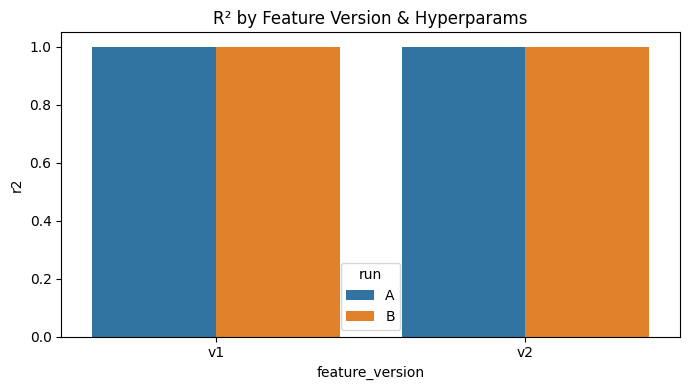

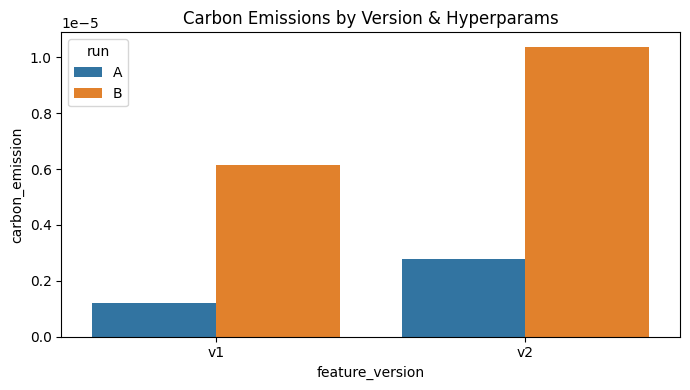

,feature_version,run,r2,carbon_emission,r2_per_kg
0,v1,A,0.998913,0.000001,830551.642769
1,v1,B,0.999049,0.000006,162723.298288
2,v2,A,0.999480,0.000003,358053.591211
3,v2,B,0.999502,0.000010,96320.532791


In [68]:
display(results_df)

plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="feature_version", y="r2", hue="run")
plt.title("R² by Feature Version & Hyperparams")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="feature_version", y="carbon_emission", hue="run")
plt.title("Carbon Emissions by Version & Hyperparams")
plt.tight_layout()
plt.show()

# Optional: efficiency metric
eff = results_df.assign(r2_per_kg = results_df["r2"] / results_df["carbon_emission"].replace(0, np.nan))
eff[["feature_version","run","r2","carbon_emission","r2_per_kg"]]
